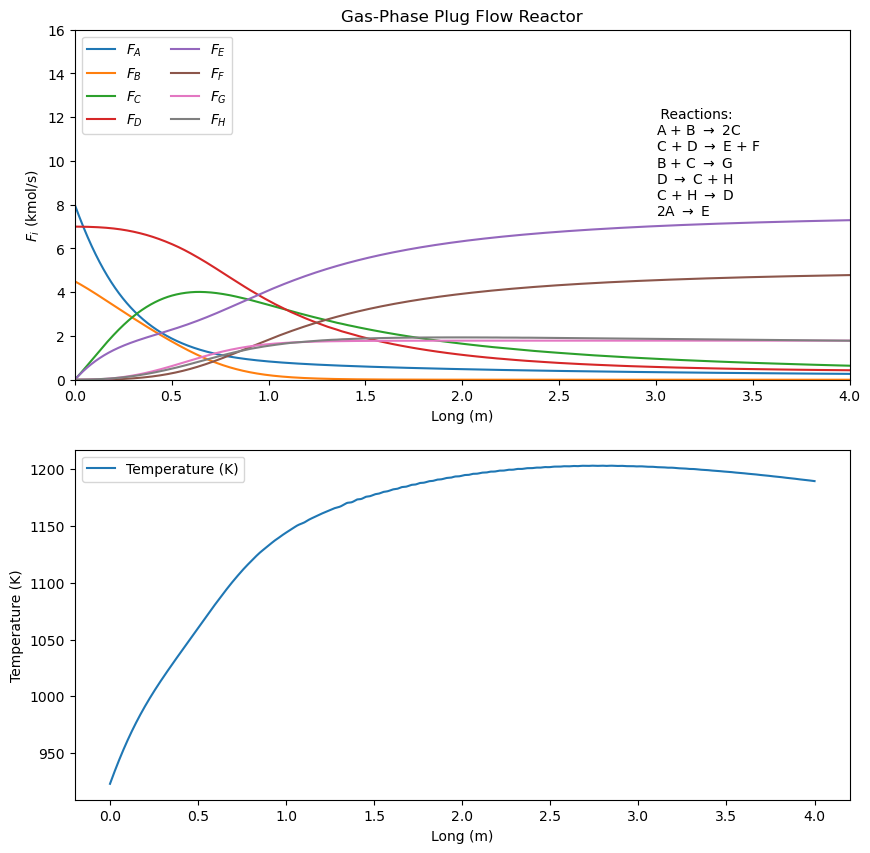

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# R-gas constant 
Rg = 8.314 # kJ/kmol/K

# Pre-exponential factor
k = np.array([1.9e12, 6.9e14, 1.5e14, 3.2e16, 7.4e13, 7.2e8]) # s-1
    
# Activation of Energy
Ea = np.array([103930, 176020, 148010, 251020, 129710, 42450]) # kJ/kmol
    
# Thermodynamic data    
Tref = 298 # K
    
dHref = np.array([-7100, 12300, -9200, 13500, -13500, -5800]) # kJ/kmol
    
Cp = np.array([41, 74, 56, 40, 29, 22, 35, 49]) # kJ/kmol/K

# Initial operation conditions of reactor    
P0 = 130 # Pa
T0 = 650+273 # K
    
# Reactor data    
L0 = 4 # Length of reactor (m)
D = 0.3 # Diameter of reactor (m)
S = np.pi*((D/2)**2) # cross section of reactor (m2)
U = 25 # Thermal coefficient (kJ/m2/s/K)
  
# Feed     
FA0 = 480/60 # kmol/s
FB0 = 270/60 # kmol/s
FD0 = 420/60 # kmol/s
    
Fi0 = np.array([FA0, FB0, 0, FD0, 0, 0, 0, 0]) # Initial molar flow

Qv0 = np.sum(Fi0)*Rg*T0/P0 # Initial volumetric flow rate

# Matrix of stoichiometric coefficients
# 1    2     3     4     5     6     7     8
# A    B     C     D     E     F     G     H

alfa = np.array([
        [-1, -1, 2, 0, 0, 0, 0, 0],
        [ 0,  0,-1,-1, 1, 1, 0, 0],
        [ 0, -1,-1, 0, 0, 0, 1, 0],
        [ 0,  0, 1,-1, 0, 0, 0, 1],
        [ 0,  0,-1, 1, 0, 0, 0,-1],
        [-2,  0, 0, 0, 1, 0, 0, 0],
        ], dtype=float)

Nreactions, Ncomponents = alfa.shape

def diff_eqs(L, y):

    F = y[:-2] # kmol/s
    Q = y[-2]  # kJ
    T = y[-1]  # K
        
    # Mass balance        
    Qv = Qv0*np.sum(F)*T/np.sum(Fi0)/T0
    C = F/Qv
    ri = np.ones(Nreactions)

    # Reaction rate equations       
    ri[0] = k[0]*np.exp(-Ea[0]/(8.31*T))*C[0]*C[1]
    ri[1] = k[1]*np.exp(-Ea[1]/(8.31*T))*C[2]*C[3]
    ri[2] = k[2]*np.exp(-Ea[2]/(8.31*T))*C[1]*C[2]
    ri[3] = k[3]*np.exp(-Ea[3]/(8.31*T))*C[3]
    ri[4] = k[4]*np.exp(-Ea[4]/(8.31*T))*C[2]*C[7]
    ri[5] = k[5]*np.exp(-Ea[5]/(8.31*T))*C[0]*C[0]

        
    # Differential equations
    dFdL = np.dot(ri, alfa)*S
        
    # Energy balance       
    q = U*(2*np.pi*D/2)*(10+273.15-T)
        
    dQdL = q
        
    # Enthalpy
    dCp = np.dot(alfa, Cp)
    dH = dHref + dCp * (T-Tref)
    rH = np.dot(ri, dH)
        
    # Differential equations
    nCp = np.dot(F, Cp)
    dTdL = (dQdL-S*rH)/ nCp
    
    dy = np.append(dFdL, [dQdL, dTdL])
    
    return dy


Q0 = 0 # Initial

y0 = [FA0, FB0, 0, FD0, 0, 0, 0, 0, Q0, T0]
L  =  np.linspace(0, L0, 100000)   # length of the reactor gride

sol = solve_ivp(diff_eqs, [L[0], L[-1]], y0, t_eval=L)

FA  = sol.y[0] # kmol/s
FB  = sol.y[1] # kmol/s
FC  = sol.y[2] # kmol/s
FD  = sol.y[3] # kmol/s
FE  = sol.y[4] # kmol/s
FF  = sol.y[5] # kmol/s
FG  = sol.y[6] # kmol/s
FH  = sol.y[7] # kmol/s

Q = sol.y[8] # heat
T = sol.y[9] # K

fig, ax = plt.subplots(nrows=2, ncols=1,  figsize=(10,10))

ax[0].plot(sol.t, FA, sol.t, FB, sol.t, FC, sol.t, FD, sol.t, FE, sol.t, FF, sol.t, FG, sol.t, FH)
ax[0].legend(['$F_A$','$F_B$','$F_C$','$F_D$','$F_E$','$F_F$','$F_G$','$F_H$'], loc='upper left', fontsize = 10, ncol=2)
ax[0].set_title('Gas-Phase Plug Flow Reactor')
ax[0].set_xlim([0, 4])
ax[0].set_ylim([0, 16])

ax[0].set_xlabel('Long (m)')

ax[0].set_ylabel('$F_{i}$ (kmol/s)')


ax[0].text(3, 7.5, r''' Reactions:
A + B $\rightarrow$ 2C
C + D $\rightarrow$ E + F
B + C $\rightarrow$ G
D $\rightarrow$ C + H
C + H $\rightarrow$ D
2A $\rightarrow$ E''')

ax[1].plot(sol.t, T)
ax[1].set_xlabel('Long (m)')
ax[1].set_ylabel('Temperature (K)' )
ax[1].legend(['Temperature (K)'])